# Robot arm simulator

In this example a simulated IMU is attached to the end effector of a robot arm.
We use the [Robotics Toolbox for
Python](https://github.com/petercorke/robotics-toolbox-python) to simulate and
control the robot.

## Setup

The robot is a Franka Emika Panda, an earlier version of the current [Franka
Robotics Research 3](https://franka.de/).  A velocity controller moves the
gripper to a sequence of positions and orientations relative to its starting
position. The toolbox simulates the underlying kinematics at 100Hz. The pose of
the end effector forms the input for InertialSim.

## Simulate the robot

The robot is commanded to move its end effector through a series of four poses
relative to its initial position.  A highly damped velocity controller sets the
joint angles required to achieve each pose.  Once a pose is achieved the next
pose in the sequence is loaded.

In [1]:
# -----------------------------------------------------------------------------
# Copyright (c) 2023-2025, Inertial Simulation LLC.
# All rights reserved.
# Do not use or redistribute without permission.
# Email: info@inertialsim.com
# Note: The Robotics Toolbox for Python is distributed under the MIT license.
#       https://github.com/petercorke/robotics-toolbox-python
# -----------------------------------------------------------------------------
%matplotlib widget

import numpy as np
import roboticstoolbox as rtb
import spatialmath as sm
from swift import Swift

env = Swift()
env.launch(headless=True)
# Uncomment for real-time interactive visualization
# env.launch(realtime=True, browser="notebook")

# Make a panda model and set its joint angles to the ready joint configuration
panda = rtb.models.Panda()
panda.q = panda.qr

# Create a sequence of target end effector pose as offsets from the initial pose
current_pose = panda.fkine(panda.q)
target_poses = (
    current_pose
    * sm.SE3.Tx(0.1)
    * sm.SE3.Tz(0.2)
    * sm.SE3.Rz([0, np.pi / 2, 0, 0])
    * sm.SE3.Rx([-np.pi / 4, 0, np.pi / 4, 0])
)

# Add the robot to the simulator
env.add(panda)

# Save the simulation time and pose variables
time = 0.0
poses = [np.array(current_pose)]

# Simulate the robot
dt = 0.01
for target_pose in target_poses:
    arrived = False
    while not arrived:
        # Calculate the required end-effector velocity to go towards the goal
        v, arrived = rtb.p_servo(current_pose, target_pose, threshold=0.02)

        # Set the Panda's joint velocities
        panda.qd = np.linalg.pinv(panda.jacobe(panda.q)) @ v

        # Step the simulator
        env.step(dt)

        # Save the state
        current_pose = panda.fkine(panda.q)
        time += dt
        poses.append(current_pose)

<video autoplay loop>
    <source src="../images/robot_arm.webm" type="video/webm">
</video>

## Create the input and simulate a realistic IMU

The pose outputs are converted to InertialSim types and then input to a
simulated [Bosch BMI270][inertialsim.devices.bosch_bmi270] IMU.

The measured angular rates (gyro) and specific forces (accelerometer) are
plotted.  Specific forces account for gravity.  In this case, InertialSim uses a
fixed value (`9.81 m/s/s`) that matches the (non-standard) default in the
Robotics Toolbox for Python simulation.

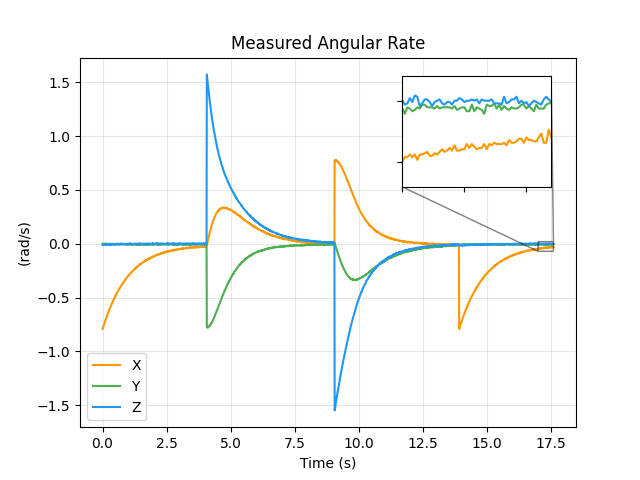

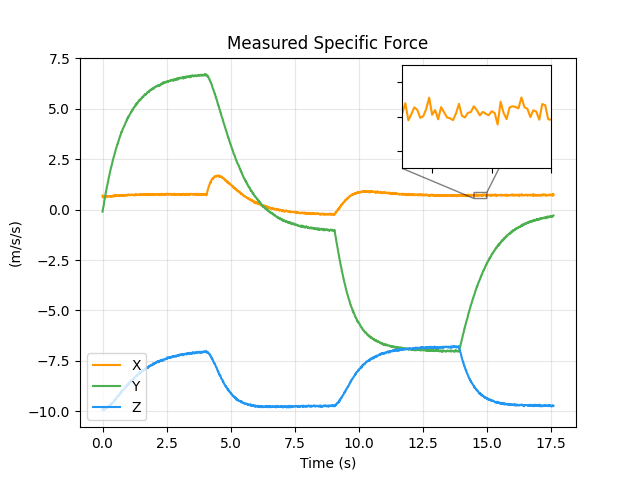

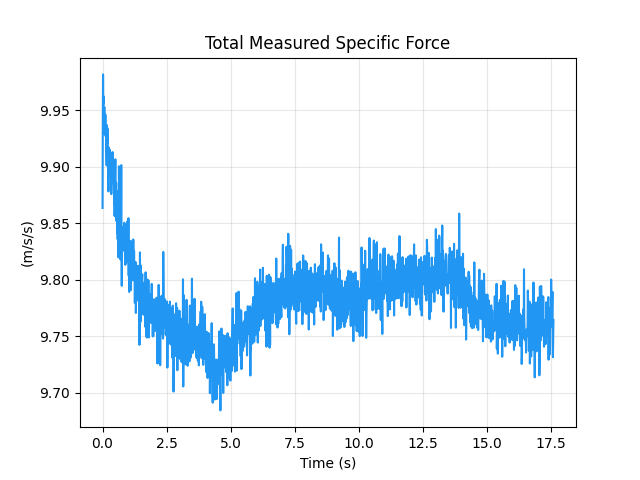

In [2]:
from inertialsim.devices import bosch_bmi270
from inertialsim.geodesy import GlobalPose
from inertialsim.geometry import Pose
from inertialsim.plot import TimeSeries
from inertialsim.sensors.imu import IMU, IMUModel
from inertialsim.time import span

# Create an InertiaSim pose object to store the Robotics Toolbox for Python
# simulation output.  This is not strictly necessary but is a convenient
# one-to-one mapping from the equivalent Robotics Toolbox type.
time_stamps = span(0.0, round(time, 2), dt)
pose = Pose.from_homogeneous_matrix(poses, time_stamps)

# Create a global pose object using the Robotics Toolbox for Python's gravity
# value and world frame axis ordering convention (X-forward, Y-left, Z-up in
# robot base frame).
global_pose = GlobalPose.from_local(
    time=time_stamps,
    attitude=pose.as_attitude(),
    position=pose.as_position(),
    velocity=None,
    gravity=[0, 0, -9.81],
)

# Create an IMU with default model settings and Analog Devices ADIS16490
# specifications
imu = IMU(IMUModel(), bosch_bmi270, rng=0)

# Simulate the IMU response to the input
result = imu.simulate(global_pose=global_pose)
angular_rate = result.gyro.angular_rate
specific_force = result.accelerometer.specific_force

# Plot gyro data
w_plot = TimeSeries(title="Measured Angular Rate", ylabel="(rad/s)")
w_plot.line(angular_rate.time, angular_rate.data)
w_plot.zoom_inset([0.65, 0.65, 0.3, 0.3], [17, 17.6], [-0.07, 0.02])
w_plot.legend(["X", "Y", "Z"], loc="lower left")

# Plot accelerometer data
a_plot = TimeSeries(title="Measured Specific Force", ylabel="(m/s/s)")
a_plot.line(specific_force.time, specific_force.data)
a_plot.zoom_inset([0.65, 0.7, 0.3, 0.28], [14.5, 15], [0.55, 0.85])
a_plot.legend(["X", "Y", "Z"], loc="lower left")

# Plot total (3-axis normed) accelerometer data
g_plot = TimeSeries(title="Total Measured Specific Force", ylabel="(m/s/s)")
g_plot.line(
    specific_force.time, np.linalg.norm(specific_force.data, axis=1), color="#2196F3"
)

## Analyzing the result

Because the simulation is kinematic (no forces, torque, inertia or other
dynamics), the angular rate is able to respond almost instantaneously when new
pose targets are loaded.  A critically damped response to each new pose target
is visible in both gyro and accelerometer measurements.  The [Bosch
BMI270][inertialsim.devices.bosch_bmi270] accelerometers are noisy and at rest,
measure an approximately `0.05 m/s/s` bias with respect to gravity (`9.76 m/s/s`
measured v. `9.81 m/s/s` simulated).